# **Scheduling Algorithm**
---
---

1.FCFS

2.RR

3.SJF

4.SRTF

5.Priority(Preemptive)

6.Priority(Non-Preemptive)

---

> ***`Common Term`*** : AT(arrival time), BT(bust time or serve time), FT(finish time), TAT(turn around time), WT(waste time)

---

> **small number have higher priority**

---




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DataFrame:
   Process AT BT Priority
0       A  0  3        4
1       B  2  6        2
2       C  4  4        1
3       D  6  5        3
4       E  8  2        5 



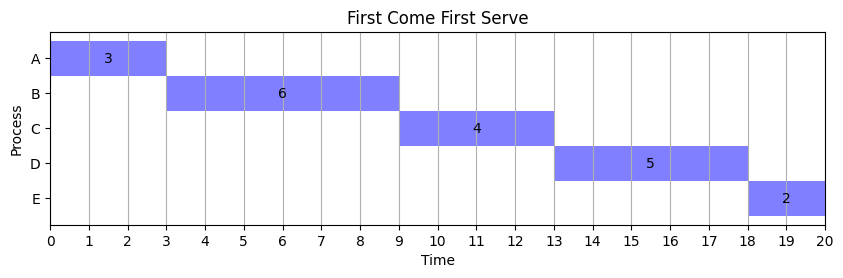


Average TAT:  8.6

Average WT:  4.6


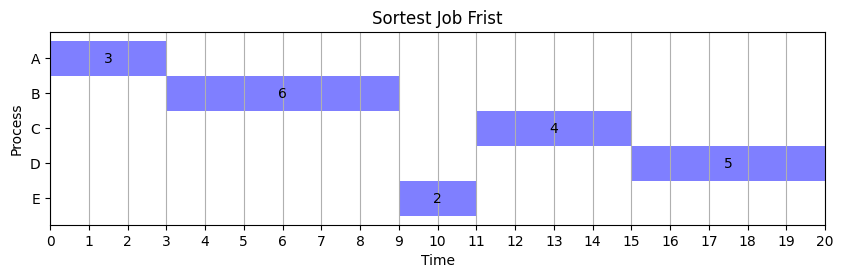


Average TAT:  8.1

Average WT:  4.1


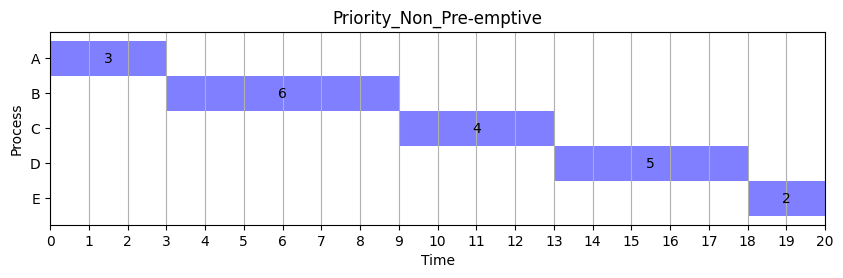


Average TAT:  8.266666666666667

Average WT:  4.266666666666667


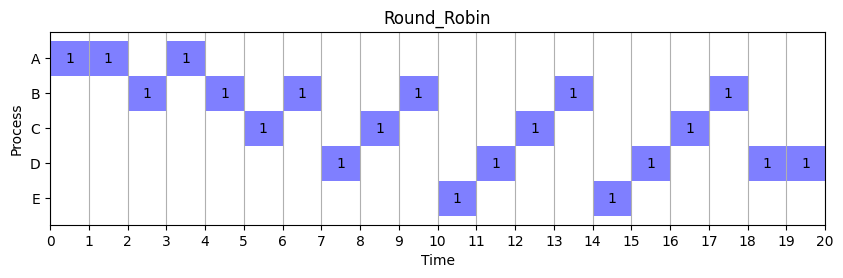

[['A', [(0, 1), (1, 2), (3, 4)]], ['B', [(2, 3), (4, 5), (6, 7), (9, 10), (13, 14), (17, 18)]], ['C', [(5, 6), (8, 9), (12, 13), (16, 17)]], ['D', [(7, 8), (11, 12), (15, 16), (18, 19), (19, 20)]], ['E', [(10, 11), (14, 15)]]]

Average TAT:  8.9

Average WT:  4.9


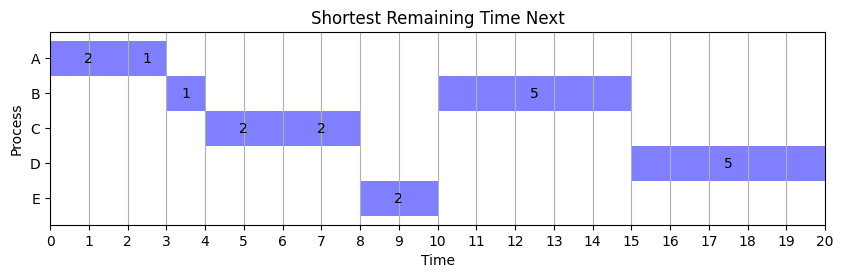

[['A', [(0, 2), (2, 3)]], ['B', [(3, 4), (10, 15)]], ['C', [(4, 6), (6, 8)]], ['D', [(15, 20)]], ['E', [(8, 10)]]]

Average TAT:  8.56

Average WT:  4.56


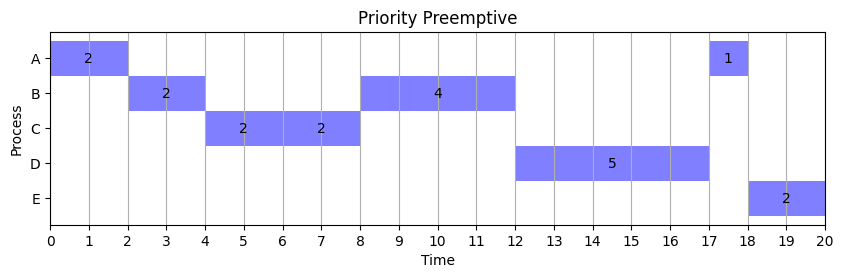

[['A', [(0, 2), (17, 18)]], ['B', [(2, 4), (8, 12)]], ['C', [(4, 6), (6, 8)]], ['D', [(12, 17)]], ['E', [(18, 20)]]]

Average TAT:  8.966666666666667

Average WT:  4.966666666666667


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import auth
import gspread
from queue import PriorityQueue

# Authenticate user
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheet
sheet_name = 'data'
sh = gc.open(sheet_name)
worksheet = sh.sheet1
data = worksheet.get_all_values()
df = pd.DataFrame(data[1:], columns=data[0])
print("DataFrame:\n", df,"\n")

# Sorting DataFrame based on AT
df['AT'] = pd.to_numeric(df['AT'])
df_sorted = df.sort_values(by='AT')

# Assigning values for common use
at = [[row['Process'], int(row['AT'])] for index, row in df_sorted.iterrows()]
bt = [[row['Process'], int(row['BT'])] for index, row in df_sorted.iterrows()]
priority = [[row['Process'], int(row['Priority'])] for index, row in df_sorted.iterrows()]
process = [row['Process'] for index, row in df_sorted.iterrows()]

ft=[]
tat=[]
wt=[]
# tq = int(input("Enter Time Quantum: "))
tq=1

size = len(df) #size of data or process

tasks = [[process[i], []] for i in range(size)]

# Function for Gantt Chart
def gantt_chart(tasks,xlim,name):
    fig, ax = plt.subplots(figsize=(10, len(tasks) * 0.5)) #(x-len,y-len)
    for task_info in tasks:
        task, ranges = task_info[0], task_info[1]
        for start, end in ranges:
            ax.barh(y=task, width=end - start, left=start, height=1, color='blue', alpha=0.5)
            ax.text(start + (end - start) / 2, task, (end-start), ha='center', va='center', color='black') #(x,y,write,...)

    ax.set_yticks(np.arange(len(tasks)))
    ax.set_yticklabels([task_info[0] for task_info in tasks])
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, xlim+1))
    ax.set_ylabel('Process')
    ax.set_xlabel('Time')
    ax.set_xlim(0, xlim)
    ax.set_title(name)
    ax.grid(axis="x")
    plt.show()


tasks = [[process[i], []] for i in range(size)]
xlim = 0

# FCFS
def FCFS():
    name = "First Come First Serve"
    tasks = [[process[i], []] for i in range(size)]
    avg_tat = 0
    avg_wt = 0
    remain_at = at.copy()
    pq1 = PriorityQueue()
    pq2 = PriorityQueue()

    end = remain_at[0][1]

    while remain_at:
        for i in range(len(remain_at)):
            if remain_at[i][1] <= end:
                temp = remain_at[i][0]
                for j in range(size):
                    if temp == at[j][0]:
                        pq1.put((at[j][1], bt[j][1]))
                        pq2.put((at[j][1], j))
                        break

        if not pq1.empty():
            arrival, serve = pq1.get()
            arrivl, pos = pq2.get()

            if (arrival > end):
                end = arrival

            start = end
            end = start + serve
            tasks[pos][1].append((start, end))

            remain_at.remove([x for x in remain_at if x[0] == at[pos][0]][0])

            xlim = end
            ft.append(end)
            tat.append(ft[-1]-at[pos][1])
            wt.append(tat[-1]-bt[pos][1])

            while not pq1.empty():
                pq1.get()
                pq2.get()
        elif pq1.empty():
            end = remain_at[0][1]

    tasks = sorted(tasks, key=lambda x:(x[0]))
    gantt_chart(tasks, xlim, name)
    avg_tat = sum(tat) / len(tat)
    avg_wt = sum(wt) / len(wt)
    print("\nAverage TAT: ",avg_tat)
    print("\nAverage WT: ",avg_wt)

# SJF
def SJF():
    name = "Sortest Job Frist"
    tasks = [[process[i], []] for i in range(size)]
    avg_tat = 0
    avg_wt = 0
    remain_at =  at.copy()
    pq1 = PriorityQueue()
    pq2 = PriorityQueue()

    end = remain_at[0][1]

    while remain_at:
        for i in range(len(remain_at)):
            if int(remain_at[i][1]) <= end:
                temp = remain_at[i][0]
                for j in range(size):
                    if temp == at[j][0]:
                        pq1.put((bt[j][1], at[j][1]))
                        pq2.put((bt[j][1], j))
                        break

        if not pq1.empty():
            serve, arrival = pq1.get()
            serv, pos = pq2.get()

            if (arrival > end):
                end = arrival

            start = end
            end = start + serve
            tasks[pos][1].append((start, end))

            remain_at.remove(at[pos])

            xlim = end
            ft.append(end)
            tat.append(ft[-1]-at[pos][1])
            wt.append(tat[-1]-bt[pos][1])

            while not pq1.empty():
                pq1.get()
                pq2.get()
        else:
            end = remain_at[0][1]

    tasks = sorted(tasks, key=lambda x:(x[0]))
    gantt_chart(tasks, xlim, name)
    avg_tat = sum(tat) / len(tat)
    avg_wt = sum(wt) / len(wt)
    print("\nAverage TAT: ",avg_tat)
    print("\nAverage WT: ",avg_wt)

#Priority Non-Preemptive
def Priority_NonPreemptive():
    name = "Priority_Non_Pre-emptive"
    tasks = [[process[i], []] for i in range(size)]
    avg_tat = 0
    avg_wt = 0
    # remain_at = [[row[0], int(0)] for row in at] #if you want AT 0 for all
    remain_at = [[row[0], int(row[1])] for row in at] #at.copy()
    pq1 = PriorityQueue()
    pq2 = PriorityQueue()

    end = remain_at[0][1]

    while remain_at:
        for i in range(len(remain_at)):
            if remain_at[i][1] <= end:
                temp = remain_at[i][0]
                for j in range(size):
                    if temp == at[j][0]:
                        pq1.put((priority[j][1], at[j][1]))
                        pq2.put((priority[j][1], j))
                        break

        if not pq1.empty():
            serv, arrival = pq1.get()
            prio, pos = pq2.get()

            if arrival > end:
                end = arrival

            serve = bt[pos][1]
            start = end
            end = start + serve
            tasks[pos][1].append((start, end))

            remain_at.remove([x for x in remain_at if x[0] == at[pos][0]][0])

            xlim = end
            ft.append(end)
            tat.append(ft[-1]-at[pos][1])
            wt.append(tat[-1]-bt[pos][1])

            while not pq1.empty():
                pq1.get()
                pq2.get()
        else:
            end = remain_at[0][1]

    tasks = sorted(tasks, key=lambda x:(x[0]))
    gantt_chart(tasks, xlim, name)
    avg_tat = sum(tat) / len(tat)
    avg_wt = sum(wt) / len(wt)
    print("\nAverage TAT: ", avg_tat)
    print("\nAverage WT: ", avg_wt)

# Round Robin
def RR():
    name = "Round_Robin"

    tasks = [[process[i], []] for i in range(size)]

    remain_at = [[row[0], int(row[1])] for row in at]
    remain_bt = [[row[0], int(row[1])] for row in bt]
    remain_bt2 = [[row[0], int(row[1])] for row in bt]
    end = 0

    xlim=0
    flag = True
    pulse = 0
    count = 0

    while remain_at:

        temp = []
        temp2 = []

        #travel whole
        for i in range(len(remain_at)):
            if remain_at[i][1] <= pulse:
                wait = pulse - remain_at[i][1]
                temp.append([remain_at[i], wait, i])

        #sorting temp
        sorted_temp = sorted(temp, key=lambda x: x[1], reverse=True) #remain_at,wait,index

        #if gap
        if not sorted_temp:
          pulse += tq
          continue

        #temp2 of same arrival value
        mx_value = sorted_temp[0][1]
        for i in range(len(sorted_temp)):
            if sorted_temp[i][1] == mx_value:
                temp2.append([remain_bt[sorted_temp[i][2]][1], sorted_temp[i][2]]) #remain_bt,index

        #if same arrival time (second thumb rule)
        flag2 = True
        for i in range(len(temp2)):
            if temp2[i][0] == remain_bt2[temp2[i][1]][1]:
                flag2 = False

                pos = i
                #serve time
                serve = min(tq, remain_bt[temp2[pos][1]][1])

                #if ideal btw two process
                end = max(end, remain_at[temp2[pos][1]][1])

                start = end
                end = start + serve
                if serve > 0:
                    for ch in range(len(tasks)):
                        if tasks[ch][0] == remain_at[temp2[pos][1]][0]:
                            tasks[ch][1].append((start, end))

                #update at
                remain_at[temp2[pos][1]][1] = end
                #update bt
                remain_bt[temp2[pos][1]][1] -= serve


                if remain_bt[temp2[pos][1]][1] == 0:
                    #remove completed process
                    remain_at = [mv for mv in remain_at if mv[0] != remain_bt[temp2[pos][1]][0]]
                    remain_bt2 = [mv for mv in remain_bt2 if mv[0] != remain_bt[temp2[pos][1]][0]]
                    remain_bt = [mv for mv in remain_bt if mv[0] != remain_bt[temp2[pos][1]][0]]
                    count += 1

                pulse += serve
                xlim = max(xlim, end)
                break

        #First thumb rule - most waiting will get cpu
        if flag2:
            #selectiong first
            pos = 0

            #serve time
            serve = min(tq,remain_bt[temp2[pos][1]][1])

            #if ideal btw two process
            end = max(end,remain_at[temp2[pos][1]][1])

            start = end
            end = start + serve
            if serve > 0:
                for ch in range(len(tasks)):
                    if tasks[ch][0] == remain_at[temp2[pos][1]][0]:
                        tasks[ch][1].append((start, end))


            #update at
            remain_at[temp2[pos][1]][1] = end
            #update bt
            remain_bt[temp2[pos][1]][1] -= serve

            if remain_bt[temp2[pos][1]][1] == 0:
                #remove completed process
                remain_at = [mv for mv in remain_at if mv[0] != remain_bt[temp2[pos][1]][0]]
                remain_bt2 = [mv for mv in remain_bt2 if mv[0] != remain_bt[temp2[pos][1]][0]]
                remain_bt = [mv for mv in remain_bt if mv[0] != remain_bt[temp2[pos][1]][0]]
                count += 1

            pulse += serve
            xlim = max(xlim, end)

    #other things
    tasks = sorted(tasks, key=lambda x:(x[0]))
    gantt_chart(tasks, xlim, name)
    print(tasks)

    for i in range(size):
        ft.append(tasks[i][-1][-1][1])
        tat.append(ft[-1] - at[i][1])
        wt.append(tat[-1] - bt[i][1])

    # print("\n",ft,tat,wt)
    avg_tat = sum(tat) / len(tat)
    avg_wt = sum(wt) / len(wt)
    print("\nAverage TAT: ",avg_tat)
    print("\nAverage WT: ",avg_wt)


def SRTN():
  name = "Shortest Remaining Time Next"

  tasks = [[process[i], []] for i in range(size)]

  remain_at = [[row[0], int(row[1])] for row in at]
  remain_bt = [[row[0], int(row[1])] for row in bt]
  remain_bt2 = [[row[0], int(row[1])] for row in bt]
  end = 0
  next_arrival = [int(x[1]) for x in at]
  next_arrival.pop(0)
  next_arrival.append(999)

  xlim = 0
  flag = True
  pulse = 0
  count = 0

  while remain_at:
    temp = []
    temp2 = []
    temp3 = []

    for i in range(len(remain_at)):
        if remain_at[i][1] <= pulse:
            wait = pulse - remain_at[i][1]
            temp.append([remain_bt[i][1], wait, i])

    # Sorting temp
    sorted_temp = sorted(temp, key=lambda x: x[0])  # remain_time, wait, index

    # If not starting with 0
    if not sorted_temp:
        pulse += 1  # Advance time if no process can be served
        continue

    # Temp3 of same remain_time
    mx_value = sorted_temp[0][0]
    for i in range(len(sorted_temp)):
        if sorted_temp[i][0] == mx_value:
            temp3.append([remain_bt[sorted_temp[i][2]][1], sorted_temp[i][1], sorted_temp[i][2]])  # remain_bt, wait, index

    sorted_temp3 = sorted(temp3, key=lambda x: x[1], reverse=True)

    # Temp2 of same arrival_time of temp3
    mx_value = sorted_temp3[0][1]
    for i in range(len(sorted_temp3)):
        if sorted_temp3[i][1] == mx_value:
            temp2.append([remain_bt[sorted_temp3[i][2]][1], sorted_temp3[i][2]])  # remain_bt, index

    flag2 = True
    for i in range(len(temp2)):
        if temp2[i][0] == remain_bt2[temp2[i][1]][1]:
            flag2 = False

            pos = i

            # If ideal between two processes
            end = max(end, remain_at[temp2[pos][1]][1])
            # Serve time
            serve = min(next_arrival[0]-end, remain_bt[temp2[pos][1]][1])
            if next_arrival[0]==end:
              if len(remain_bt)>1 and len(next_arrival)>2:
                serve=min(next_arrival[1]-end,remain_bt[temp2[pos][1]][1])

            serve = abs(serve)
            start = end
            end = start + serve

            if serve > 0:
                for ch in range(len(tasks)):
                    if tasks[ch][0] == remain_at[temp2[pos][1]][0]:
                        tasks[ch][1].append((start, end))

            # Update at
            remain_at[temp2[pos][1]][1] = end
            # Update bt
            remain_bt[temp2[pos][1]][1] -= serve
            # Update next_arrival
            if end >= next_arrival[0]:
                del next_arrival[0]

            if serve == 0:
                pulse += 1
                continue

            if remain_bt[temp2[pos][1]][1] == 0:
                # Remove completed process
                remain_at = [mv for mv in remain_at if mv[0] != remain_bt[temp2[pos][1]][0]]
                remain_bt2 = [mv for mv in remain_bt2 if mv[0] != remain_bt[temp2[pos][1]][0]]
                remain_bt = [mv for mv in remain_bt if mv[0] != remain_bt[temp2[pos][1]][0]]
                count += 1

            pulse += serve
            xlim = max(xlim, end)
            break

    # First thumb rule - most waiting will get CPU
    if flag2:

        # Selecting first
        pos = 0

        # If ideal between two processes
        end = max(end, remain_at[temp2[pos][1]][1])
        # Serve time
        serve = min(next_arrival[0]-end, remain_bt[temp2[pos][1]][1])
        if next_arrival[0]==end:
            if len(remain_bt)>1 and len(next_arrival)>2:
                serve=min(next_arrival[1]-end,remain_bt[temp2[pos][1]][1])

        serve = abs(serve)
        start = end
        end = start + serve

        if serve > 0:
            for ch in range(len(tasks)):
                if tasks[ch][0] == remain_at[temp2[pos][1]][0]:
                    tasks[ch][1].append((start, end))
        # Update at
        remain_at[temp2[pos][1]][1] = end
        # Update bt
        remain_bt[temp2[pos][1]][1] -= serve
        # Update next_arrival
        if end >= next_arrival[0]:
            del next_arrival[0]

        if serve == 0:
            pulse += 1
            continue

        if remain_bt[temp2[pos][1]][1] == 0:
            # Remove completed process
            remain_at = [mv for mv in remain_at if mv[0] != remain_bt[temp2[pos][1]][0]]
            remain_bt2 = [mv for mv in remain_bt2 if mv[0] != remain_bt[temp2[pos][1]][0]]
            remain_bt = [mv for mv in remain_bt if mv[0] != remain_bt[temp2[pos][1]][0]]
            count += 1

        pulse += serve
        xlim = max(xlim, end)



  # Other things
  tasks = sorted(tasks, key=lambda x:(x[0]))
  gantt_chart(tasks, xlim, name)
  print(tasks)

  for i in range(size):
      ft.append(tasks[i][-1][-1][1])
      tat.append(ft[-1] - at[i][1])
      wt.append(tat[-1] - bt[i][1])

  # print("\n", ft, tat, wt)
  avg_tat = sum(tat) / len(tat)
  avg_wt = sum(wt) / len(wt)
  print("\nAverage TAT: ", avg_tat)
  print("\nAverage WT: ", avg_wt)




def Priority_Preemptive():
  name = "Priority Preemptive"

  tasks = [[process[i], []] for i in range(size)]

  remain_at = [[row[0], int(row[1])] for row in at]
  remain_bt = [[row[0], int(row[1])] for row in bt]
  remain_prio = [[row[0], int(row[1])] for row in priority]
  end = 0

  next_arrival = [int(x[1]) for x in at]
  next_arrival.pop(0)
  next_arrival.append(999)

  xlim = 0
  flag = True
  pulse = 0
  count = 0

  while remain_at:
    temp = []
    temp2 = []

    for i in range(len(remain_at)):
        if remain_at[i][1] <= pulse:
            prio = remain_prio[i][1]
            temp.append([remain_at[i], prio, i])

    # Sorting temp
    sorted_temp = sorted(temp, key=lambda x: x[1])  # remain_time, wait, index

    # If not starting with 0
    if not sorted_temp:
        pulse += 1  # Advance time if no process can be served
        continue

    # making temp2
    for i in range(len(sorted_temp)):
        temp2.append([remain_bt[sorted_temp[i][2]][1], sorted_temp[i][2]]) #remain_bt,index


    # Selecting first
    pos = 0

    # If ideal between two processes
    end = max(end, remain_at[temp2[pos][1]][1])
    # Serve time
    serve = min(next_arrival[0]-end, remain_bt[temp2[pos][1]][1])
    if next_arrival[0]==end:
        if len(remain_bt)>1 and len(next_arrival)>2:
            serve=min(next_arrival[1]-end,remain_bt[temp2[pos][1]][1])

    serve = abs(serve)
    start = end
    end = start + serve

    if serve > 0:
        for ch in range(len(tasks)):
            if tasks[ch][0] == remain_at[temp2[pos][1]][0]:
                tasks[ch][1].append((start, end))

    # Update at
    remain_at[temp2[pos][1]][1] = end
    # Update bt
    remain_bt[temp2[pos][1]][1] -= serve
    # Update next_arrival
    if end >= next_arrival[0]:
        next_arrival.pop(0)

    if serve == 0:
        pulse += 1
        continue

    if remain_bt[temp2[pos][1]][1] == 0:
        # Remove completed process
        remain_at = [mv for mv in remain_at if mv[0] != remain_bt[temp2[pos][1]][0]]
        remain_prio = [mv for mv in remain_prio if mv[0] != remain_bt[temp2[pos][1]][0]]
        remain_bt = [mv for mv in remain_bt if mv[0] != remain_bt[temp2[pos][1]][0]]
        count += 1

    pulse += serve
    xlim = max(xlim, end)

  # Other things
  tasks = sorted(tasks, key=lambda x:(x[0]))
  gantt_chart(tasks, xlim, name)
  print(tasks)

  for i in range(size):
      ft.append(tasks[i][-1][-1][1])
      tat.append(ft[-1] - at[i][1])
      wt.append(tat[-1] - bt[i][1])

  # print("\n", ft, tat, wt)
  avg_tat = sum(tat) / len(tat)
  avg_wt = sum(wt) / len(wt)
  print("\nAverage TAT: ", avg_tat)
  print("\nAverage WT: ", avg_wt)


# Calling RR function
FCFS()
SJF()
Priority_NonPreemptive()
RR()
SRTN()
Priority_Preemptive()

